### 1. EMWs
- __DONE__ write own ema (take only past values)
- __DONE__ several curves, criterion activated by several emws
- add sell

### 2. Self-similarity
- detect minima by yt vid
- maybe some similarity measure

### 3. 
- test on datasets by day? week

- log or not?

- class with train, where coeffs and thrs are chosen, and test,

- draw graph of profit with graph of coin

# sell proportional to delta after thr

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime as dt

In [2]:
df = pd.read_csv('CDD/gemini_BTCUSD_1hr.csv')
df = df.reset_index()
df.columns = df.iloc[0]
df = df.iloc[1:].sort_values('Date').reset_index(drop=True)
for col in df.columns[-5:]:
    df.loc[:, col] = df[col].astype(float)

price_df = df
price_df['DT'] = pd.to_datetime(price_df.Date)
price_df['Date'] = price_df.DT.dt.date


In [3]:
WINDOW_SIZES = [7, 14, 28, 56, 224, 700, 1400]

def add_ewm(df, price_col='Close'):
    for ws in WINDOW_SIZES:
        ewm = df[price_col].ewm(span=ws).mean()
        df.loc[:, f'ewm_{ws}'] = ewm

add_ewm(price_df, price_col='Close')

from sklearn.linear_model import Lasso
def add_exp_trend(df, price_col='Close'):
    xs = np.array(list(df.index))
    ys = np.log(df.Close.values)

    model = Lasso()
    model.fit(xs.reshape(-1, 1), ys.reshape(-1, 1))
    preds = model.predict(xs.reshape(-1, 1))

    a = model.coef_[0]
    b = preds[0] - xs[0] * a
    df.loc[:, 'exp_trend'] = np.exp(preds)
    return a, b

add_exp_trend(price_df)

def plot(df, cols, dt_col='DT', buy_column=None, sell_column=None, height=0.0005, name='graph'):
    plt.figure(figsize=(20,10))
    for col in cols:
        plt.plot(df[dt_col], df[col])

    
    if buy_column is not None:
        buy_df = df[df[buy_column].astype(int) > 0]
        plt.vlines(buy_df.DT, buy_df.Close*(1-height), buy_df.Close*(1+height), colors='green')

    if sell_column is not None:
        sell_df = df[df[sell_column].astype(int) > 0]
        plt.vlines(sell_df.DT, sell_df.Close*(1-height), sell_df.Close*(1+height), colors='green')

    plt.legend(cols)
    plt.savefig(f'{name}.png', format='png')
    plt.show()

In [4]:
EWM_COLS = [f'ewm_{ws}' for ws in WINDOW_SIZES]
EWM_DELTA_COLS = [f'ewm_{ws}_delta' for ws in WINDOW_SIZES]


class Trader:
    def __init__(self, dt_col='DT', 
                price_col='Close'):

        self.dt_col = dt_col
        self.price_col = price_col
    
    
    def fit(self, price_df):
        target_cols = EWM_COLS + ['exp_trend']
        self.price_df = price_df[[self.dt_col, self.price_col] + target_cols].copy()
        self.price_df.columns = ['DT', 'price'] + target_cols

        self.add_indicators(self.price_df)

    
    def add_indicators(self, df, columns=EWM_COLS+['exp_trend']):
        for col in columns:
            value = df[col]
            delta = value - df.price
            df.loc[:, f'{col}_delta'] = delta / df.price
            
        df.loc[:, 'ewm_delta_sum'] = df[EWM_DELTA_COLS].sum(axis=1)
        df.loc[:, 'ewm_delta_mean'] = df[EWM_DELTA_COLS].mean(axis=1)
        return df
        

    def buy_by_indicator(self, df, column, n_calc=100):

        mean_prices = []
        thresholds = np.linspace(-1, 2, n_calc)
        for threshold in thresholds:
            buy_df = df[df[column] > threshold]
            if buy_df.shape[0] > 0:
                mean_prices.append(buy_df.price.mean())
            else:
                mean_prices.append(np.inf)
        best_price_ind = np.argmin(mean_prices)
        return mean_prices[best_price_ind], thresholds[best_price_ind]


# Predict rise

In [5]:
feature_columns = EWM_DELTA_COLS + ['ewm_delta_sum', 'ewm_delta_mean', 'exp_trend_delta']

def get_increase_pct(prices, horizon=30):
    res = np.vstack([prices.shift(-i).values for i in range(horizon)])
    max_value_in_horizon = np.nanmax(res, axis=0)
    return max_value_in_horizon / prices

In [30]:
# Train 
date_start = dt.date(year=2013, month=1, day=1)
date_end = dt.date(year=2020, month=1, day=1)
df_2017 = price_df[(price_df.Date >= date_start) & (price_df.Date < date_end)]

t = Trader()
t.fit(df_2017)
df_train = t.price_df


# Test
date_start = dt.date(year=2020, month=1, day=1)
date_end = dt.date(year=2022, month=1, day=1)
df_2018 = price_df[(price_df.Date >= date_start) & (price_df.Date < date_end)]

t = Trader()
t.fit(df_2018)
df_test = t.price_df

horizon = 30
X_train = df_train[feature_columns].iloc[:-horizon]
X_test = df_test[feature_columns].iloc[:-horizon]
y_train = get_increase_pct(df_train.price, horizon)[:-horizon]
y_test = get_increase_pct(df_test.price, horizon)[:-horizon]

In [31]:
from sklearn.linear_model import Lasso

def mse(pred, true):
    return ((pred - true)**2).mean()

def mae(pred, true):
    return (np.abs(pred - true)).mean()

def mape(pred, true):
    return (np.abs(pred - true) / np.abs(true)).mean()

In [27]:
from sklearn.ensemble import GradientBoostingRegressor

# model = Lasso()
model = GradientBoostingRegressor(n_estimators=100)
model.fit(X_train.values, y_train.values)

pred_train = model.predict(X_train.values)
true_train = y_train.values

pred_test = model.predict(X_test.values)
true_test = y_test.values

for name, func in zip(['MSE', 'MAE', 'MAPE'], [mae, mse, mape]):
    print(f'{name} on train: ', func(pred_train, true_train))
print()
for name, func in zip(['MSE', 'MAE', 'MAPE'], [mae, mse, mape]):
    print(f'{name} on test: ', func(pred_test, true_test))

MSE on train:  0.017817727861367073
MAE on train:  0.0006806397936843385
MAPE on train:  0.017031561168197925

MSE on test:  0.03551781943868045
MAE on test:  0.0022381489508792826
MAPE on test:  0.03444658460747872


In [32]:
from sklearn.ensemble import GradientBoostingRegressor

# model = Lasso()
model = GradientBoostingRegressor(n_estimators=100)
model.fit(X_train.values, y_train.values)

pred_train = model.predict(X_train.values)
true_train = y_train.values

pred_test = model.predict(X_test.values)
true_test = y_test.values

for name, func in zip(['MSE', 'MAE', 'MAPE'], [mae, mse, mape]):
    print(f'{name} on train: ', func(pred_train, true_train))
print()
for name, func in zip(['MSE', 'MAE', 'MAPE'], [mae, mse, mape]):
    print(f'{name} on test: ', func(pred_test, true_test))

MSE on train:  0.01836456858081765
MAE on train:  0.0007192906681664697
MAPE on train:  0.01754020790059963

MSE on test:  0.026033238386702993
MAE on test:  0.0014221544659367919
MAPE on test:  0.02504893921172835


In [33]:
df2buy = df_test.iloc[:-horizon][pred_test > 1.1]
df2buy.shape

(300, 20)

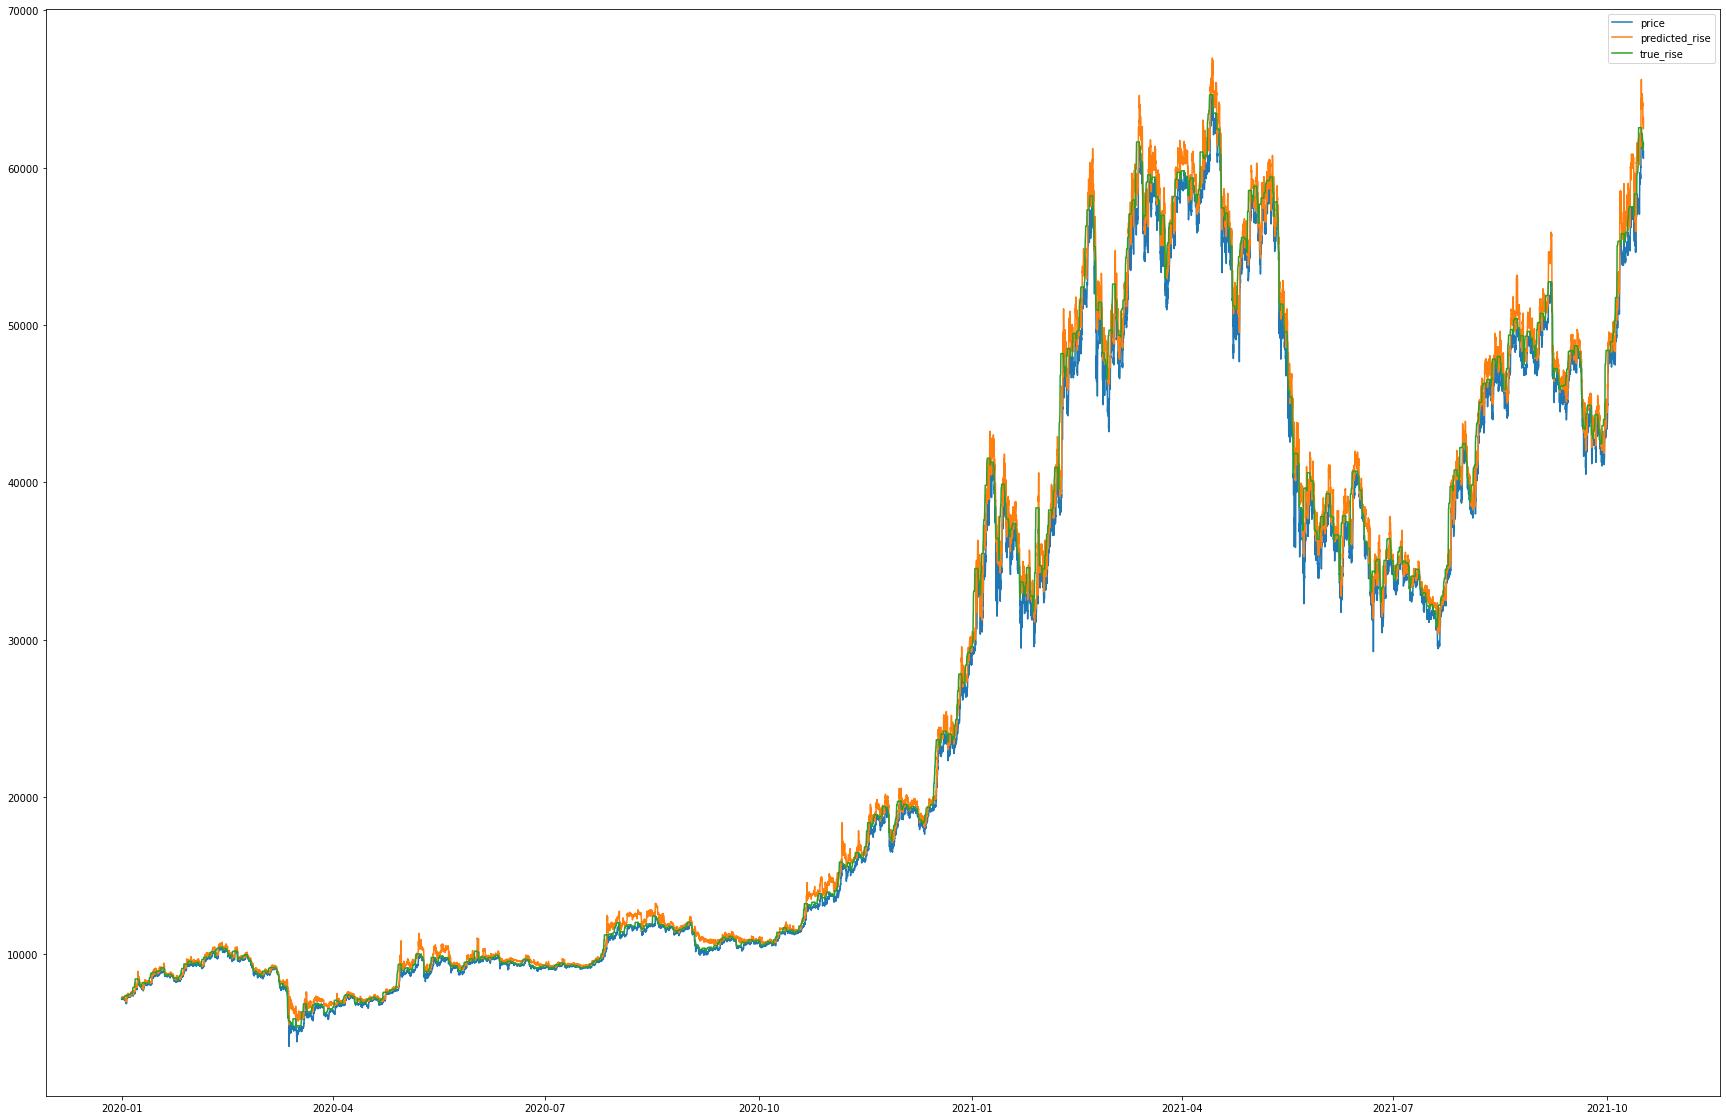

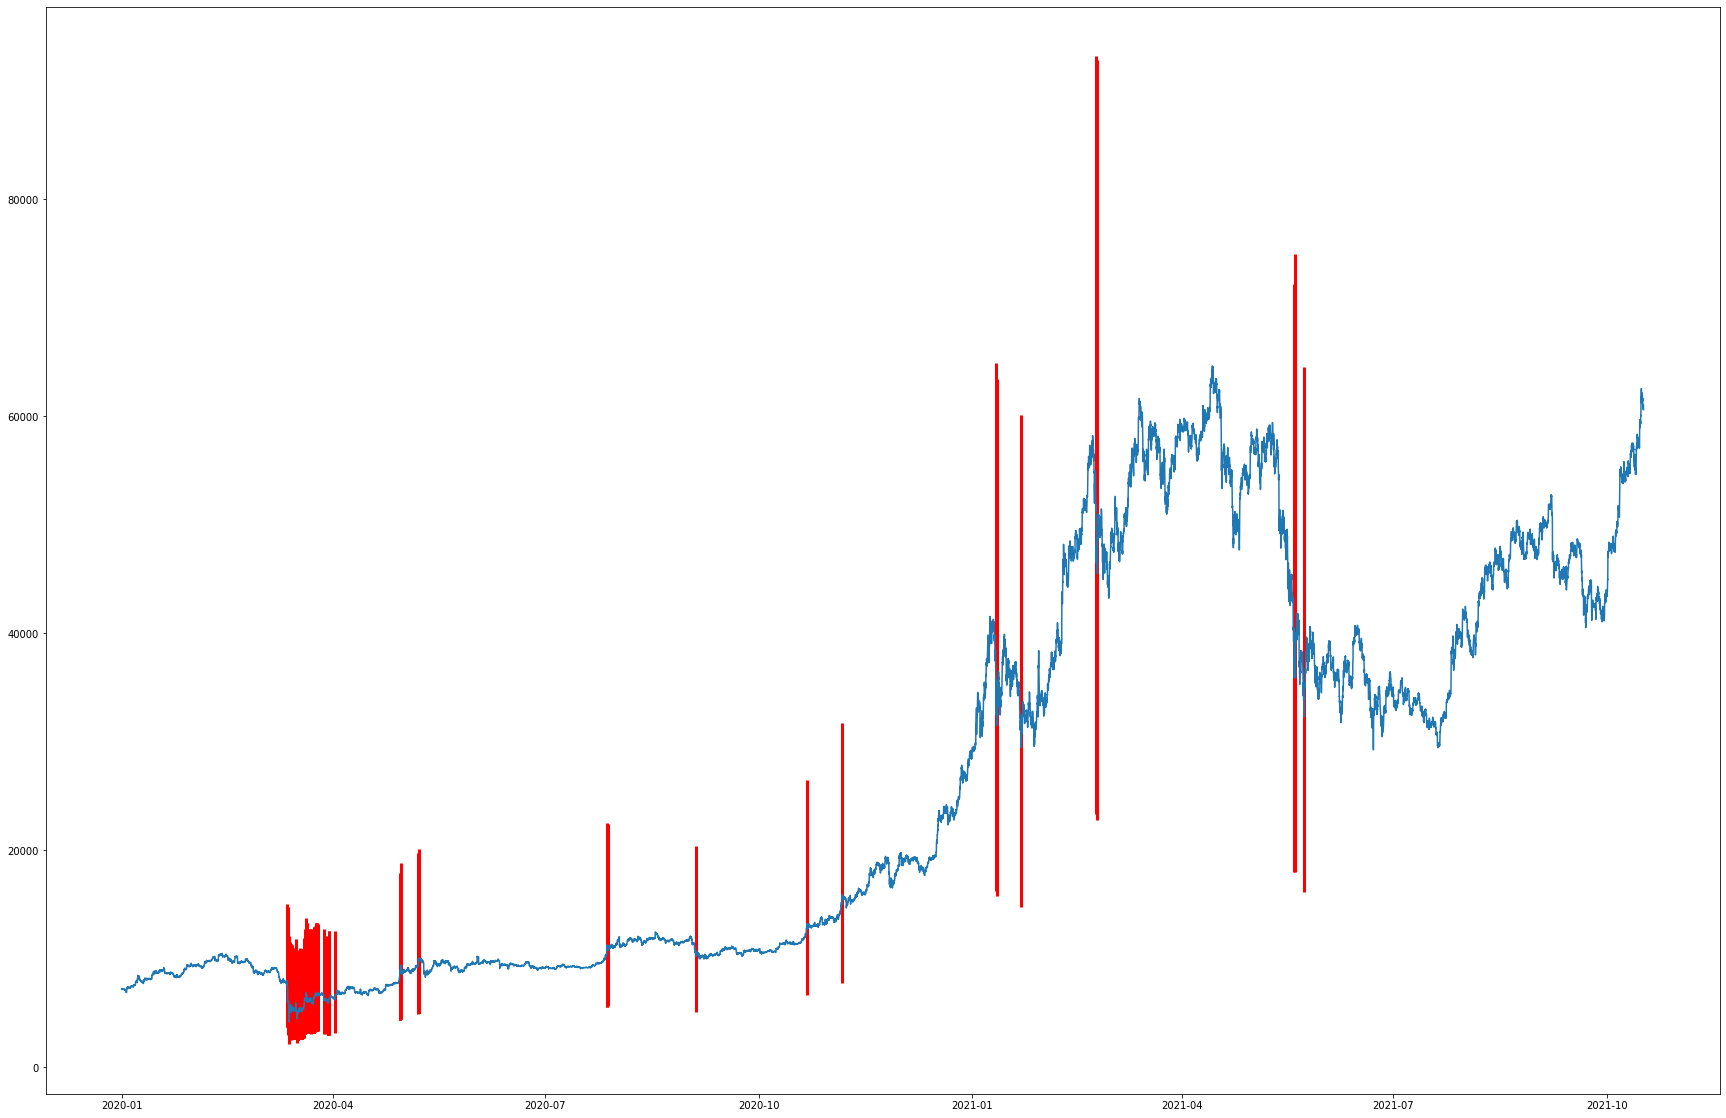

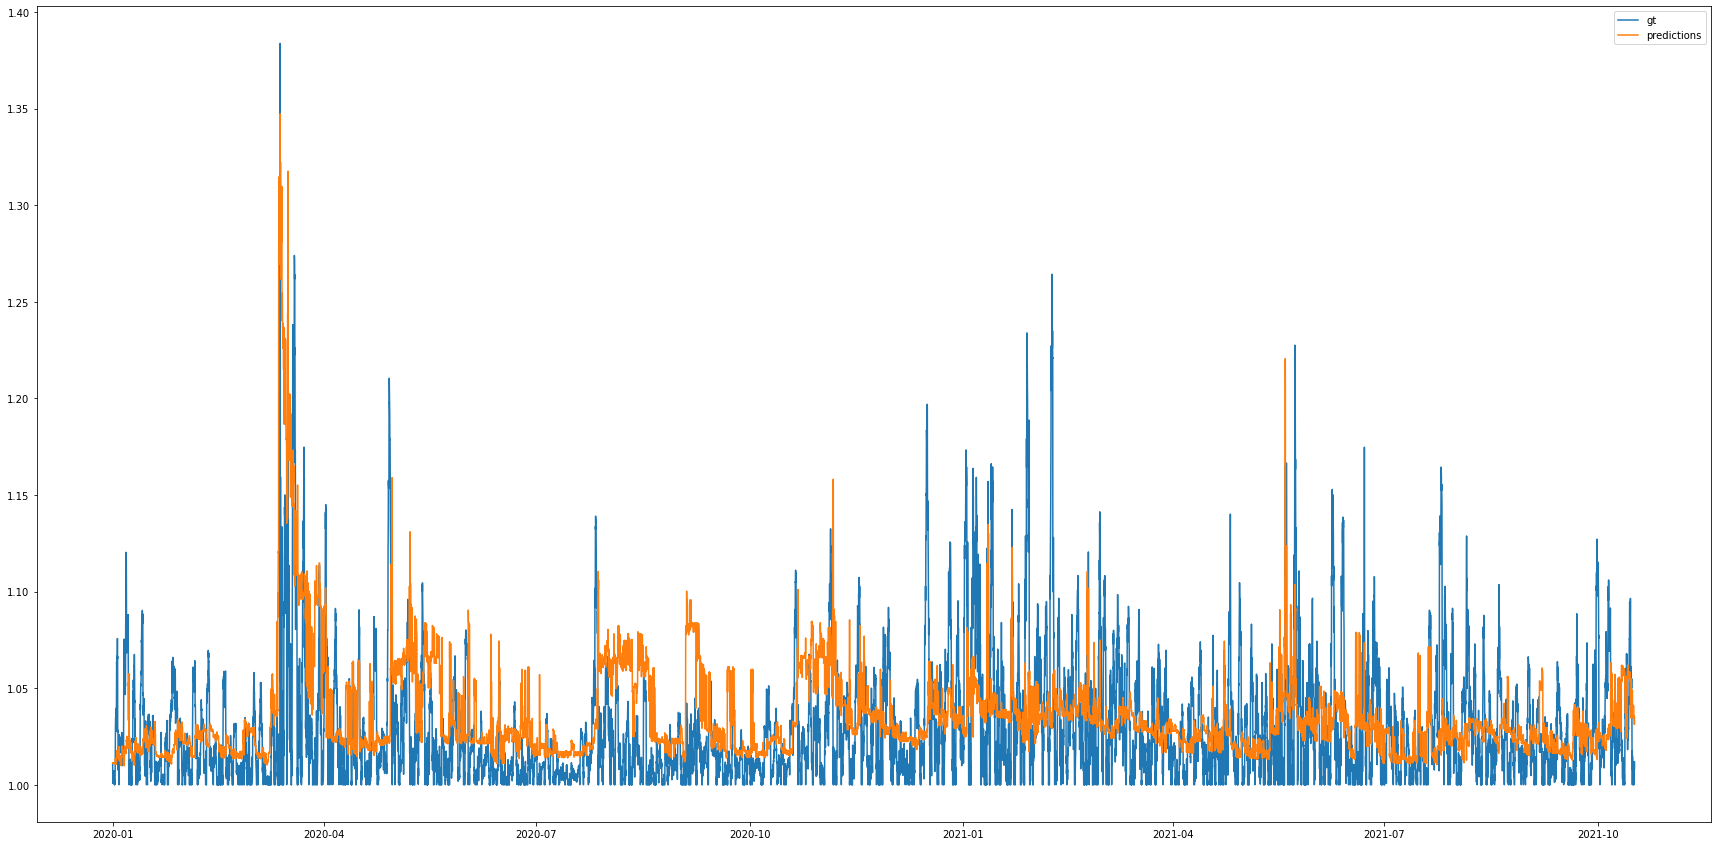

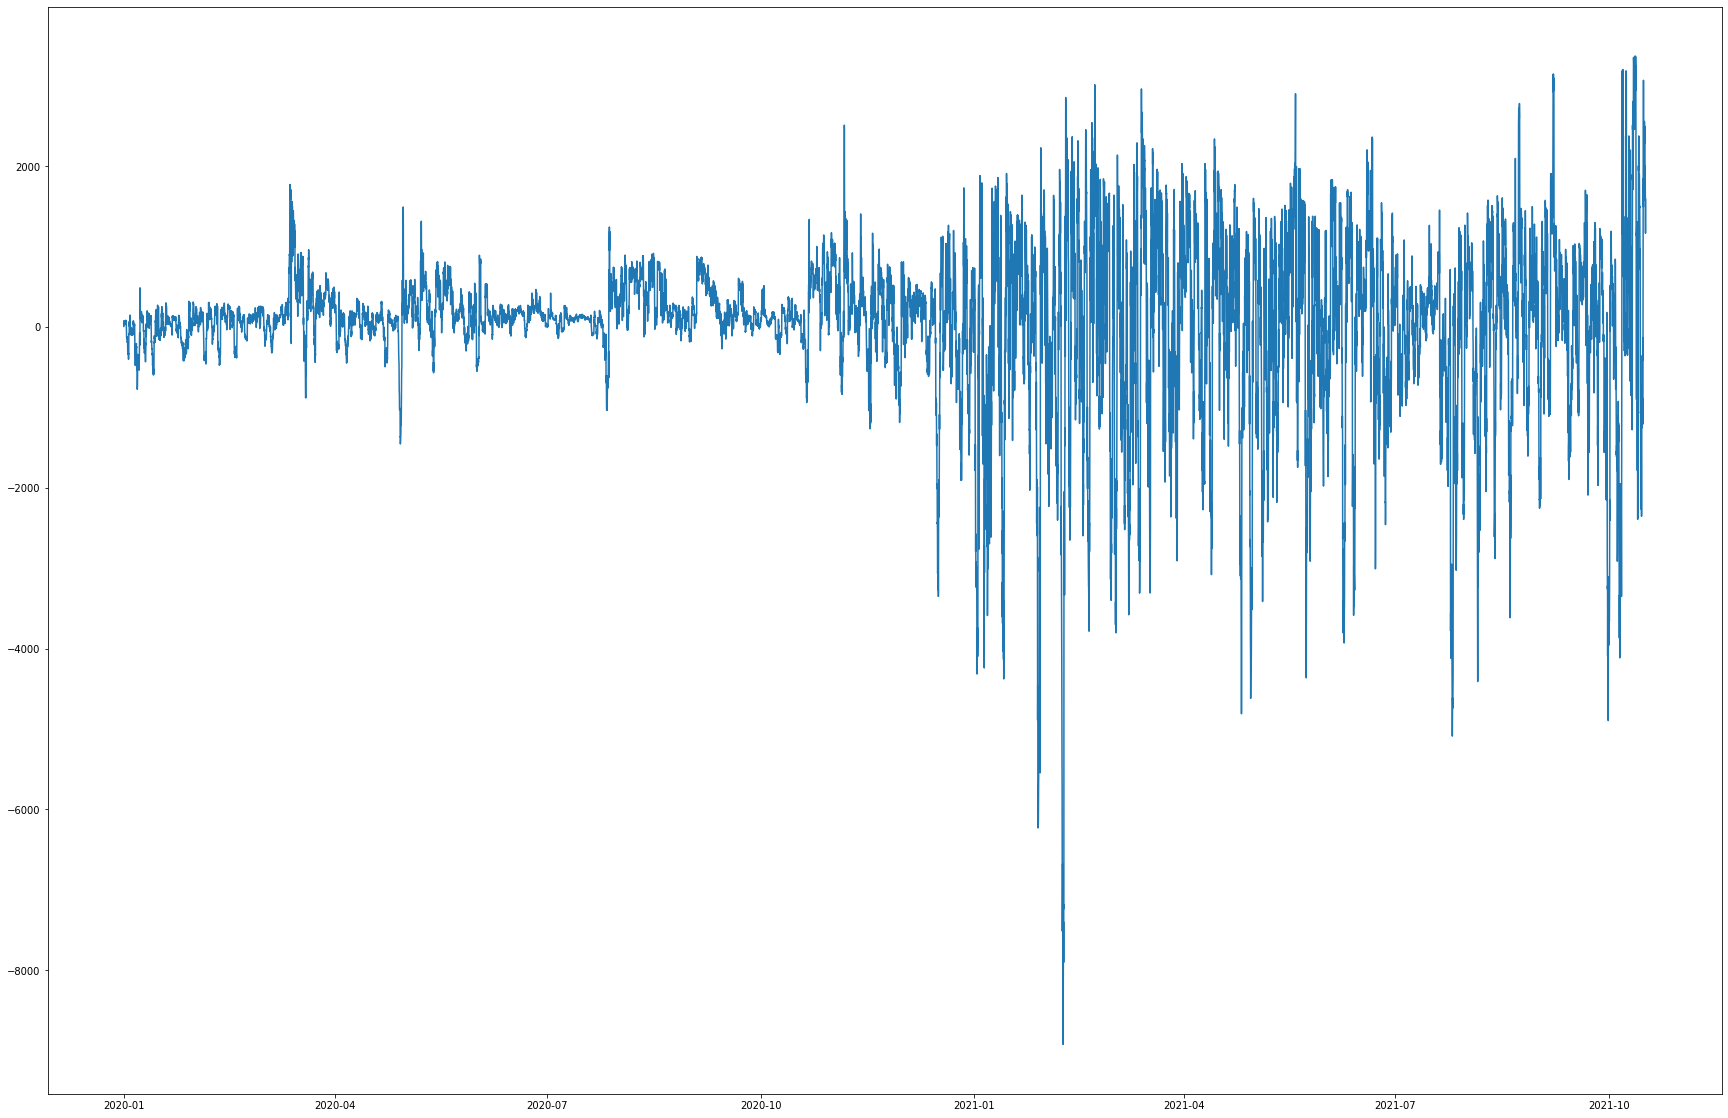

In [36]:
plt.figure(figsize=(30, 20))
xs = df_test.DT.values[:-horizon]

prices = df_test.price[:-horizon]
plt.plot(xs, prices)
plt.plot(xs, pred_test * prices)
plt.plot(xs, true_test * prices)

plt.legend(['price', 'predicted_rise', 'true_rise'])
plt.show()

plt.figure(figsize=(30, 20))
plt.plot(xs, prices)
plt.vlines(df2buy.DT, df2buy.price*0.5, df2buy.price*2, colors='r', linewidth=3)
plt.show()

plt.figure(figsize=(30, 15))
plt.plot(xs, true_test)
plt.plot(xs, pred_test)
plt.legend(['gt','predictions'])
plt.show()

plt.figure(figsize=(30, 20))
plt.plot(xs, (pred_test - true_test) * prices)
# plt.vlines(df2buy.DT, df2buy.price*0.5, df2buy.price*1.3, colors='r', linewidth=2)
plt.show()

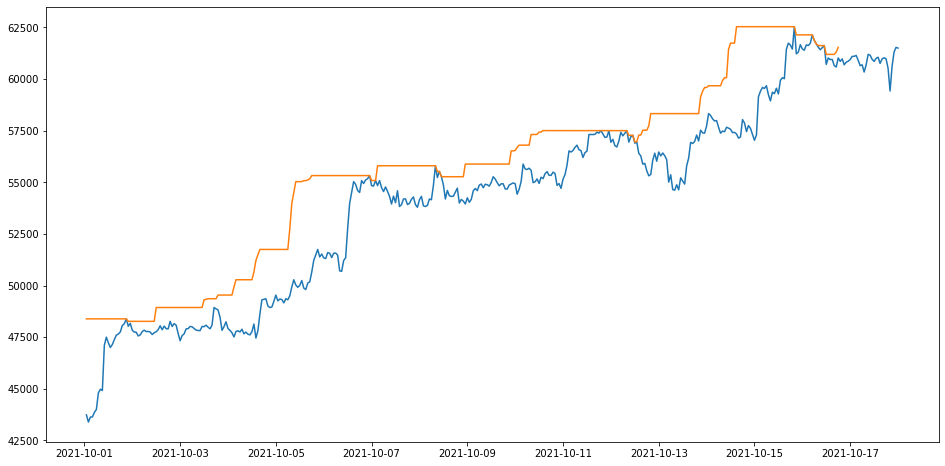

In [37]:
slice = df_test[df_test.DT > dt.datetime(year=2021, month=10, day=1, hour=0)]
rise = y_test[df_test.DT > dt.datetime(year=2021, month=10, day=1, hour=0)]

plt.figure(figsize=(16,8))
plt.plot(slice.DT, slice.price)
plt.plot(slice.DT, slice.price * rise)
plt.show()

# Pose as classification problem

In [52]:
from sklearn.metrics import roc_auc_score, roc_curve

rise_thr = 1.08
pred_train_binary = (pred_train > rise_thr).astype(int)
pred_test_binary = (pred_test > rise_thr).astype(int)

true_train_binary = (y_train > rise_thr).astype(int)
true_test_binary = (y_test > rise_thr).astype(int)

In [57]:
pred_train

array([1.01514894, 1.01514894, 1.01708538, ..., 1.01178802, 1.01178802,
       1.01065506])

In [66]:
y_binary = (y_test > 1.1).astype(int)

tprs = []
fprs = []
for thr in np.linspace(1, 1.4, 10):
    pred_binary = (pred_test > thr).astype(int)
    tp = np.sum((y_binary == 1) & (pred_binary == 1))
    fp = np.sum((y_binary == 0) & (pred_binary == 1))
    fn = np.sum((y_binary == 1) & (pred_binary == 0))
    tn = np.sum((y_binary == 0) & (pred_binary == 0))

    tpr = tp/(tp + fn)
    fpr = fp/(tn + fp)

    tprs.append(tpr)
    fprs.append(fpr)

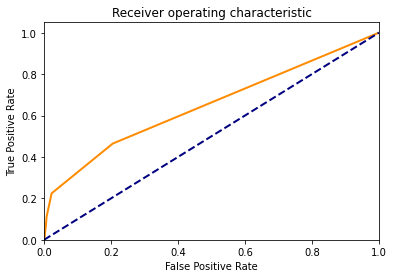

In [69]:
# fpr, tpr, _ = roc_curve(true_train_binary, pred_train_binary,)
# roc_auc = roc_auc_score(true_train_binary, pred_train_binary)
# plt.plot(fpr, tpr)

plt.figure()
lw = 2
plt.plot(
    fprs,
    tprs,
    color="darkorange",
    lw=lw,
    # label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
# plt.legend(loc="lower right")
plt.show()

<AxesSubplot:>

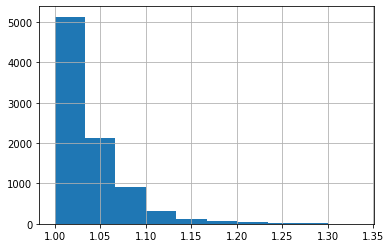

In [79]:
increase_pct.hist()

# Plot criterions

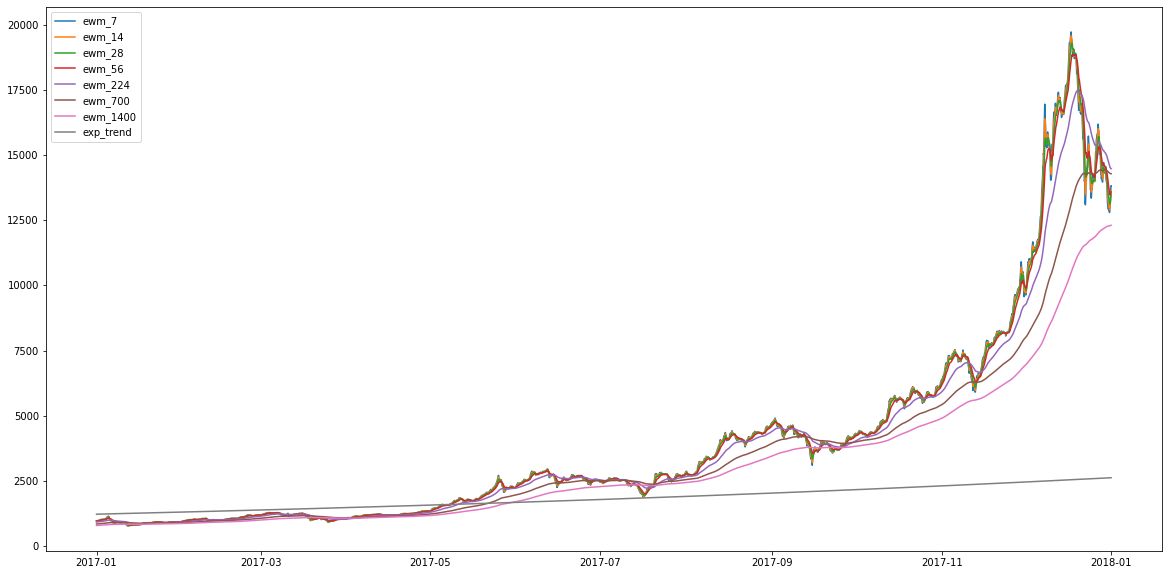

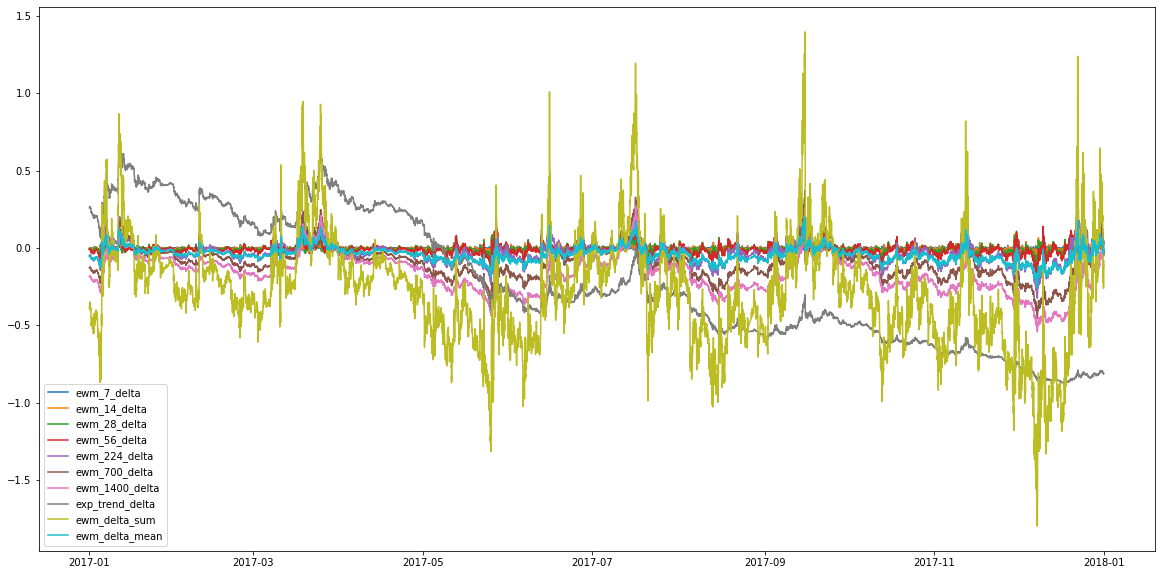

Mean buy price by ewm_delta_sum: 2325.5977027027025, Threshold=0.696969696969697
Mean buy price by ewm_delta_mean: 2580.49431372549, Threshold=0.09090909090909083
Mean buy price by exp_trend_delta: 762.5366666666667, Threshold=0.6363636363636365


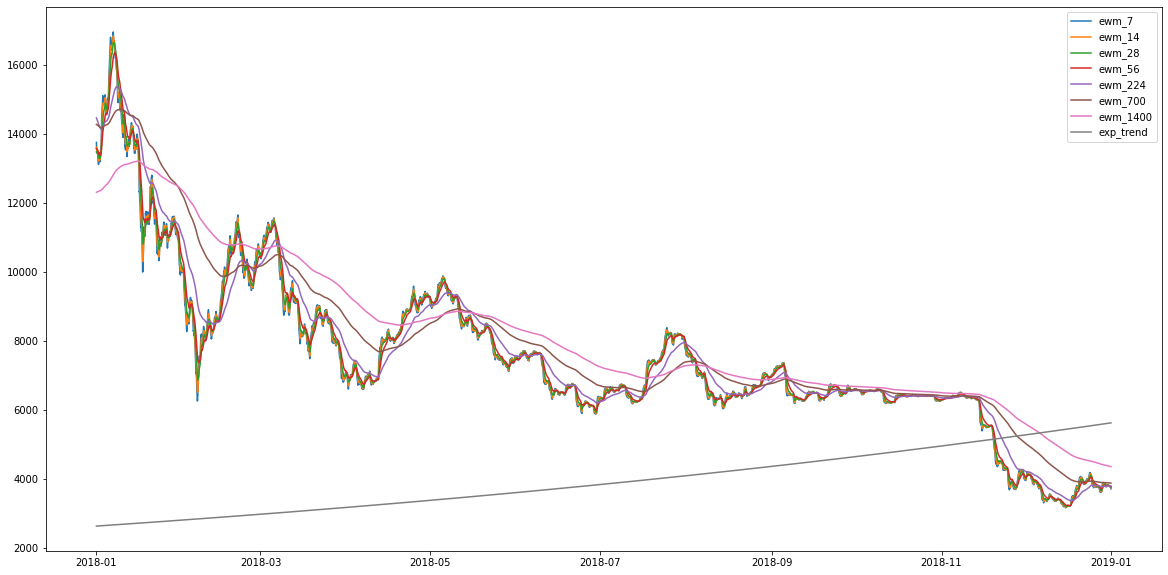

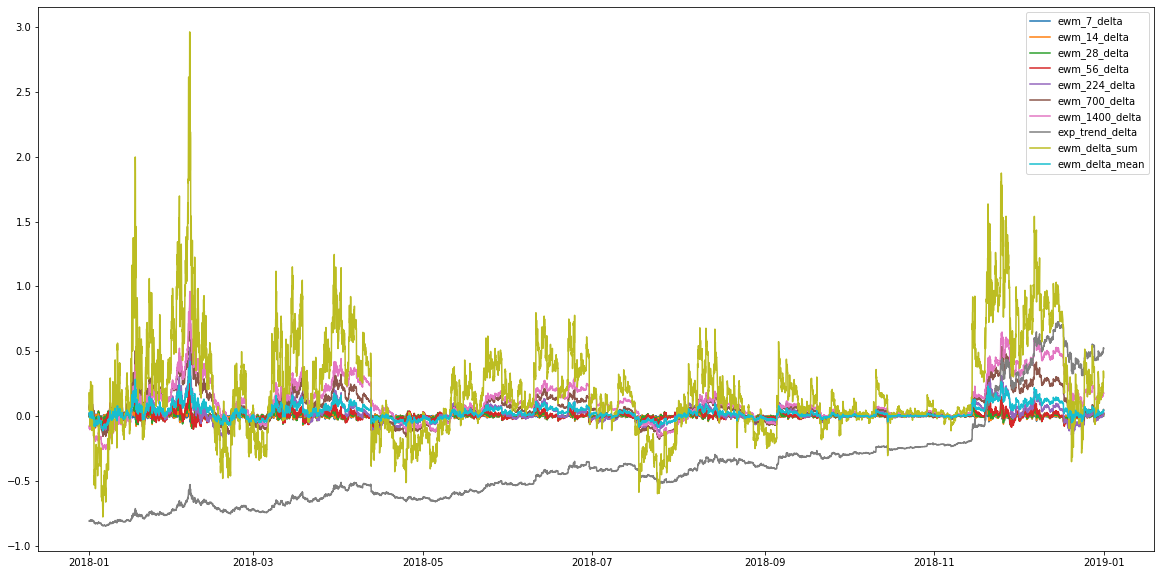

Mean buy price by ewm_delta_sum: 5512.099155124654, Threshold=0.7878787878787878
Mean buy price by ewm_delta_mean: 5547.536787479407, Threshold=0.12121212121212133
Mean buy price by exp_trend_delta: 3140.98, Threshold=0.7272727272727273


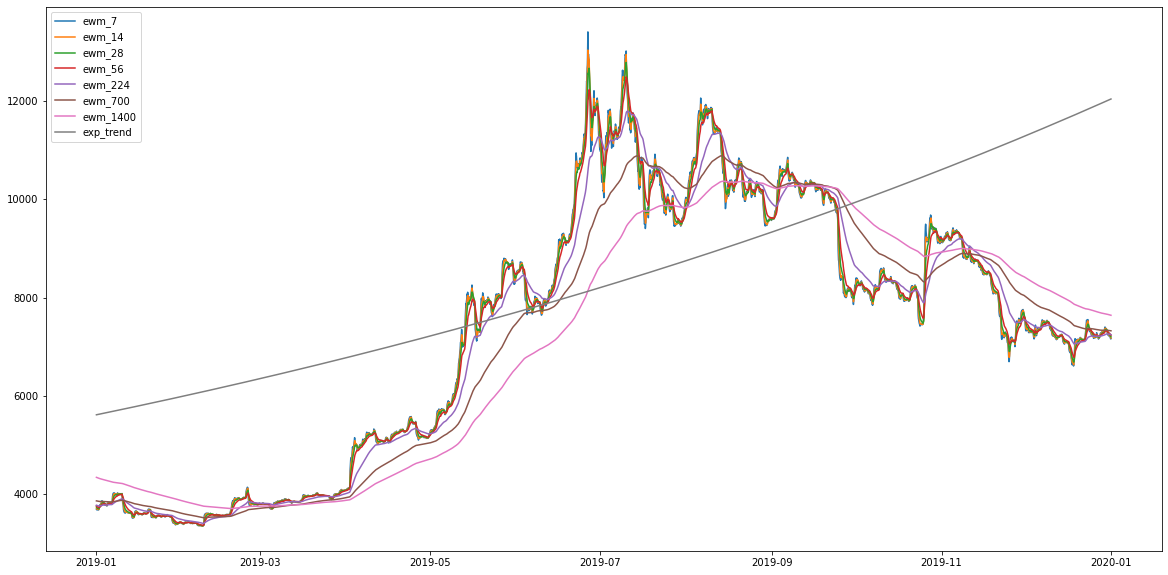

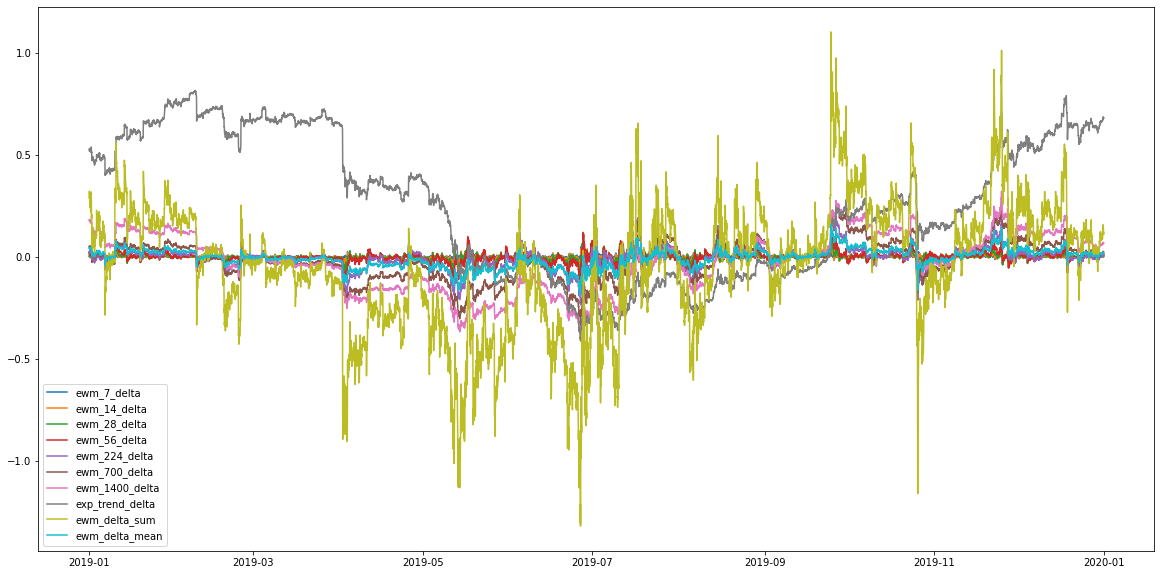

Mean buy price by ewm_delta_sum: 6912.088990851916, Threshold=0.1515151515151516
Mean buy price by ewm_delta_mean: 7069.982249518471, Threshold=-0.030303030303030276
Mean buy price by exp_trend_delta: 3419.928225806452, Threshold=0.7878787878787878


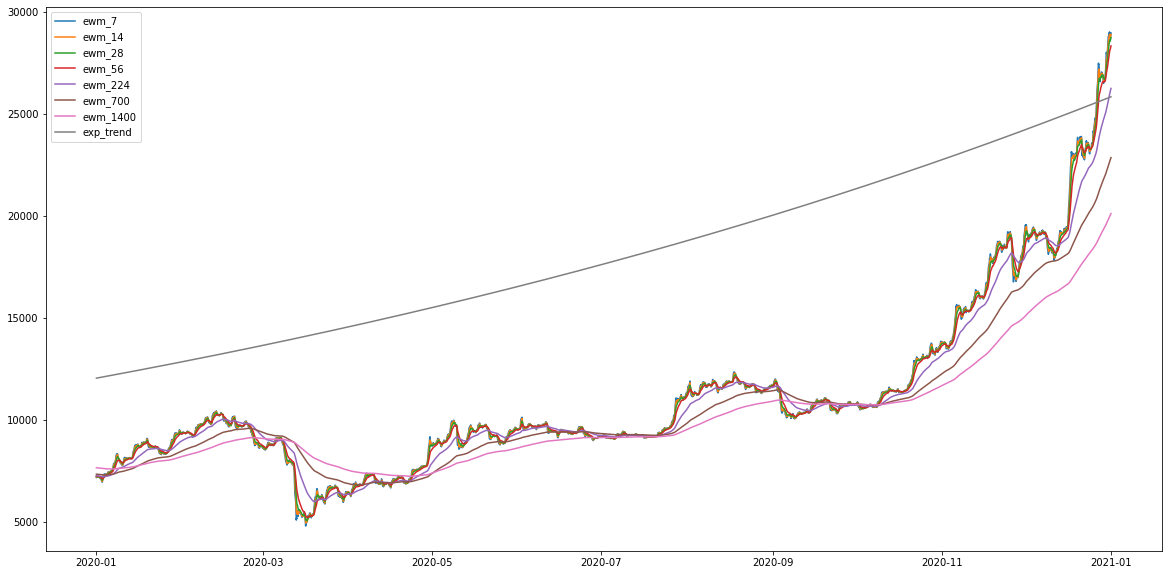

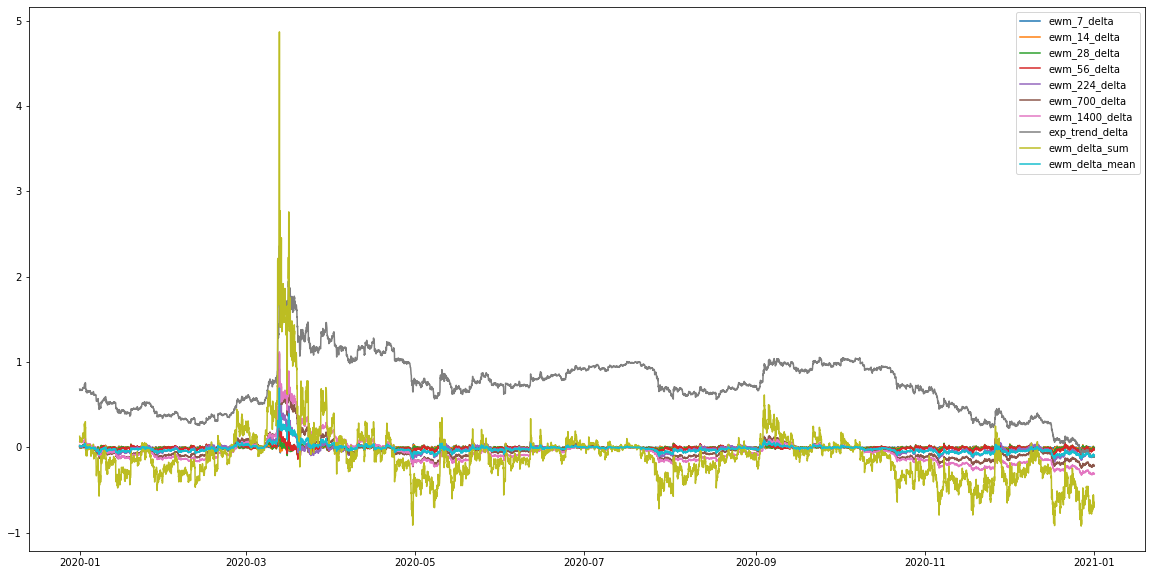

Mean buy price by ewm_delta_sum: 5149.2075, Threshold=1.9696969696969697
Mean buy price by ewm_delta_mean: 4160.0, Threshold=0.5454545454545454
Mean buy price by exp_trend_delta: 4393.21, Threshold=2.0


In [14]:
for i in range(1, 5):
    date_start = dt.date(year=2016+i, month=1, day=1)
    date_end = dt.date(year=2016+i+1, month=1, day=1)
    df = price_df[(price_df.Date >= date_start) & (price_df.Date < date_end)]

    t = Trader()
    t.fit(df)

    plot(t.price_df, EWM_COLS+['exp_trend'])
    plot(t.price_df, EWM_DELTA_COLS+['exp_trend_delta'] + ['ewm_delta_sum', 'ewm_delta_mean'])
    
    for crit in ['ewm_delta_sum', 'ewm_delta_mean', 'exp_trend_delta']:
        price, thr = t.buy_by_indicator(t.price_df, crit)
        print(f'Mean buy price by {crit}: {price}, Threshold={thr}')

# Logarithmic data

In [102]:
# for mon in range(1, 5):
#     date_start = dt.date(year=2018, month=mon, day=1)
#     date_end = dt.date(year=2019, month=mon+1, day=1)
#     df = price_df[(price_df.Date >= date_start) & (price_df.Date < date_end)]
    
#     df.loc[:, 'Close'] = np.log10(df.Close)

#     price_cols = ['ewm_7', 'ewm_14', 'ewm_28',
#         'ewm_56', 'ewm_224', 'ewm_700', 'ewm_1400']
#     indicator_cols = ['ewm_delta_7', 'ewm_delta_14', 'ewm_delta_28',
#         'ewm_delta_56', 'ewm_delta_224', 'ewm_delta_700', 'ewm_delta_1400']

#     t = Trader()
#     t.fit(df)

#     plot(t.price_df, price_cols)
#     plot(t.price_df, indicator_cols + ['ewm_sum', 'ewm_mean'])
    
#     for crit in ['ewm_sum', 'ewm_mean']:
#         price, thr = t.buy_by_indicator(t.price_df, crit)
#         print(f'Mean buy price by {crit}: {price}, Threshold={thr}')